# Music21 Exploration Template

Use this notebook to explore music21 capabilities, especially rebuilding a score (partition) from a list of notes, and assess suitability for the DataBass project.

## 1. Setup
- Install music21 if missing (commented for environments that already have it).
- Set a working directory for saving MIDI/MusicXML outputs.

In [20]:
import music21 as m21
us = m21.environment.UserSettings()

# Prefer MuseScore 3 if present
import os
mscore3 = '/usr/bin/mscore3'
mscore = '/usr/bin/mscore'

if os.path.exists(mscore3):
    us['musescoreDirectPNGPath'] = mscore3
    us['musicxmlPath'] = mscore3
    print("Configured MuseScore path:", mscore3)
elif os.path.exists(mscore):
    us['musescoreDirectPNGPath'] = mscore
    us['musicxmlPath'] = mscore
    print("Configured MuseScore path:", mscore)
else:
    print("MuseScore not found. Install musescore or musescore3.")

# Optional: set MIDI player fallback
if os.path.exists('/usr/bin/fluidsynth'):
    us['midiPath'] = '/usr/bin/fluidsynth'
elif os.path.exists('/usr/bin/timidity'):
    us['midiPath'] = '/usr/bin/timidity'

print("music21 settings OK")

Configured MuseScore path: /usr/bin/mscore
music21 settings OK


In [1]:
# If music21 is not installed, uncomment the next line
# !pip install music21

from pathlib import Path
import music21 as m21
import musescore

# Set working directory for outputs
WORKDIR = Path.cwd()
print("Working dir:", WORKDIR)
print("music21 version:", m21.__version__)

Working dir: /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/notebooks/Edgar
music21 version: 9.9.1


## 2. Load / Parse a Score
- Option A: Use music21 built-in corpus (e.g., Bach chorales)
- Option B: Load your own MIDI / MusicXML file
- Quickly inspect parts, measures, and notes.

In [2]:
# Option A: built-in corpus example
score = m21.corpus.parse('bach/bwv66.6')  # short Bach chorale
print(score)

# Option B: load your own file (uncomment and set path)
# score_path = Path("path/to/your/file.mid")
# score = m21.converter.parse(score_path)

# Inspect top-level structure
print("Parts:", [p.partName for p in score.parts]) # print the different
print("Measures count (part 0):", len(score.parts[0].getElementsByClass('Measure')))

# Show first measures
score.parts[0].measures(1, 5).show('text')

<music21.stream.Score bach/bwv66.6.mxl>
Parts: ['Soprano', 'Alto', 'Tenor', 'Bass']
Measures count (part 0): 10
{0.0} <music21.instrument.Instrument 'P1: Soprano: Instrument 1'>
{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.Key of f# minor>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.note.Note A>
    {1.0} <music21.note.Note B>
    {2.0} <music21.note.Note C#>
    {3.0} <music21.note.Note E>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.note.Note C#>
    {1.0} <music21.note.Note B>
    {2.0} <music21.note.Note A>
    {3.0} <music21.note.Note C#>
{8.0} <music21.stream.Measure 3 offset=8.0>
    {0.0} <music21.layout.SystemLayout>
    {0.0} <music21.note.Note A>
    {0.5} <music21.note.Note B>
    {1.0} <music21.note.Note G#>
    {2.0} <music21.note.Note F#>
    {3.0} <music21.note.Note A>
{12.0} <music21.stream.Measure 4 offset=12.0>
    {0.0} <music21.note.Note B>
    {1.0} <music21.note.Note B>
    {2.0} <

## 3. Extract Notes to a Table
- Flatten notes (or chords) into a list with pitch, duration, offset, part.
- Convert to pandas DataFrame for quick inspection.

In [9]:
import pandas as pd

notes_data = []
for p_idx, part in enumerate(score.parts):
    for n in part.recurse().notes:
        if n.isNote:
            pitch = n.pitch.nameWithOctave
            duration_q = n.quarterLength
            offset = float(n.offset)
            notes_data.append({
                'part': part.partName or f'Part {p_idx+1}',
                'pitch': pitch,
                'duration_q': duration_q,
                'offset_q': offset,
            })
        elif n.isChord:
            for p in n.pitches:
                duration_q = n.quarterLength
                offset = float(n.offset)
                notes_data.append({
                    'part': part.partName or f'Part {p_idx+1}',
                    'pitch': p.nameWithOctave,
                    'duration_q': duration_q,
                    'offset_q': offset,
                })

notes_df = pd.DataFrame(notes_data)
print(notes_df.head(20))
print("Total notes:", len(notes_df))

       part pitch  duration_q  offset_q
0   Soprano   C#5         0.5       0.0
1   Soprano    B4         0.5       0.5
2   Soprano    A4         1.0       0.0
3   Soprano    B4         1.0       1.0
4   Soprano   C#5         1.0       2.0
5   Soprano    E5         1.0       3.0
6   Soprano   C#5         1.0       0.0
7   Soprano    B4         1.0       1.0
8   Soprano    A4         1.0       2.0
9   Soprano   C#5         1.0       3.0
10  Soprano    A4         0.5       0.0
11  Soprano    B4         0.5       0.5
12  Soprano   G#4         1.0       1.0
13  Soprano   F#4         1.0       2.0
14  Soprano    A4         1.0       3.0
15  Soprano    B4         1.0       0.0
16  Soprano    B4         1.0       1.0
17  Soprano   F#4         1.0       2.0
18  Soprano    E4         1.0       3.0
19  Soprano    A4         1.0       0.0
Total notes: 165


## 4. Recreate a Score from a Note List
- Build a new score/part from a table of notes (pitch, duration, offset).
- Useful to validate DataBass outputs (predicted notes → partition).

In [ ]:
def build_score_from_table(df: pd.DataFrame, title: str = "Recreated "):
    """
    Build a music21 Score from a DataFrame with columns: pitch, duration_q, offset_q.
    Assumes a single part; extend as needed for multiple parts.
    """
    sc = m21.stream.Score()
    sc.metadata = m21.metadata.Metadata()
    sc.metadata.title = title

    part = m21.stream.Part()
    part.partName = "Recreated Part"

    for _, row in df.iterrows():
        n = m21.note.Note(row['pitch'])
        n.quarterLength = float(row['duration_q'])
        part.insert(float(row['offset_q']), n)

    sc.insert(0, part)
    return sc

# Example: rebuild from extracted notes (single part)
recreated = build_score_from_table(notes_df[['pitch', 'duration_q', 'offset_q']])
print(recreated) #whole partition : Score object music21
print(recreated.pitches) #notes : list of note object music 21
print(recreated.offset) #start time
# Show a text preview of the first measures
recreated.measures(1,2).show('text')

<music21.stream.Score 0x7ef4b19f4110>
[<music21.pitch.Pitch C#5>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch C#5>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch B4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch G#4>, <music21.pitch.Pitch F#4>, <music21.pitch.Pitch F#4>, <music21.pitch.Pitch E4>, <music21.pitch.Pitch F#4>, <music21.pitch.Pitch E4>, <music21.pitch.Pitch F#4>, <music21.pitch.Pitch F#4>, <music21.pitch.Pitch C#4>, <music21.pitch.Pitch F#4>, <music21.pitch.Pitch F#4>, <music21.pitch.Pitch C#4>, <music21.pitch.Pitch B3>, <music21.pitch.Pitch A3>, <music21.pitch.Pitch C#4>, <music21.pitch.Pitch A3>, <music21.pitch.Pitch C#4>, <music21.pitch.Pitch B3>, <music21.pitch.Pitch F#3>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch F#3>, <music21.pitch.Pitch B3>, <music21.pitch.Pitch A3>, <music21.pitch.Pitch F#3>, <music21.pitch.Pitch A3>, <music21.pitch.Pitch F#3>, <music21.pitch.Pitch G#3>, <music21.pitch.Pitch F#3>, <musi

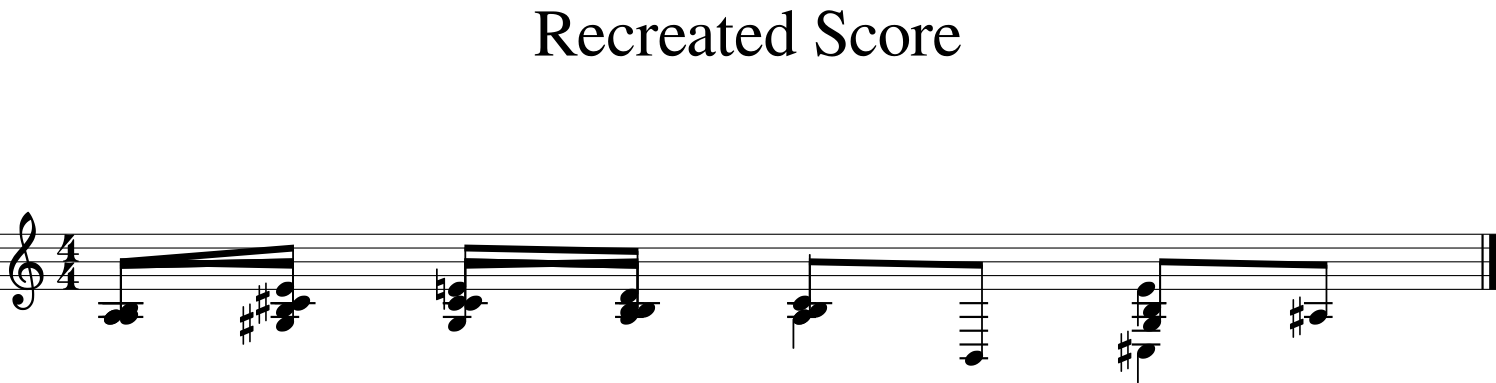

In [21]:
# This will open in MuseScore (or your default MusicXML viewer)
recreated.show()  # default uses musicxmlPath

## 5. Export / Render
- Save to MIDI and MusicXML for inspection.
- Use `.show('midi')` or `.show()` (requires environment support) to hear/see output.

In [ ]:
midi_path = WORKDIR / "recreated_score.mid"
xml_path = WORKDIR / "recreated_score.musicxml"

recreated.write('midi', fp=midi_path)
recreated.write('musicxml', fp=xml_path)

print("Saved:")
print("-", midi_path)
print("-", xml_path)

# Optional: play or view (may require a local MIDI player or MuseScore installed)
# recreated.show('midi')
# recreated.show()  # default viewer (MusicXML)

Saved:
- /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/notebooks/Edgar/recreated_score.mid
- /home/edgar/code/Arkyed/08-Project/databass-code/DataBass/notebooks/Edgar/recreated_score.musicxml


## 6. Suitability Checklist for DataBass
- Can we rebuild partitions from note lists? Yes (Section 4).
- Are durations/offsets preserved? Inspect `offset_q` and `duration_q`.
- Multi-part handling: extend builder to one Part per instrument.
- Integration path: convert model outputs (note, onset, duration) → table → MusicXML/MIDI.
- Next step: add articulations/tempo/dynamics if needed.